In [1]:
###########################################################
# MSDS 442: AI Agent Design and Development
# Spring '25
# Dr. Bader
#
# Assignment 4 - Northwestern Memorial – Healthcare Agent
# 
# Kevin Geidel
#
###########################################################

# OBJECTIVE:
#   The following will construct multiple AI agents using the LangChain & LangGraph frameworks. 
#   The agents will represent different departments of Northwestern Memorial Hospital.
#   They will coordinate, synchronize, and act to answer patients'/visitors' questions.

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Python native imports
import os, textwrap, json

# 3rd party package imports
from IPython.display import display, Image
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

# Assign experiment-wide variables
model_name = 'gpt-4o-mini'
data_dir = os.path.join('reports', 'Assignment_4')
knowledge_base_dir = os.path.join('knowledge_base')

In [2]:
# Requirement 1: Define the structure of agent state for the LangGraph
class InquiryState(TypedDict):
    inquiry: str
    referring_node: str
    next_node: str
    response: str
    messages: Annotated[Sequence[BaseMessage], "List of messages in the conversation"]

In [3]:
# Establish the AI client
llm = ChatOpenAI(model=model_name, temperature=0) 

In [4]:
# Define utils needed by the agents

def load_knowledge_base(filename):
    # Extract inquires and responses from the JSON format knowledge base
    full_path = os.path.join(knowledge_base_dir, filename)
    with open(full_path, 'r') as file:
        data = json.load(file)
    return str(data)

def get_query_from_inquiry(inquiry, messages=None):
    prompt_str = f"""Provide an answer for following user's inquiry: '{inquiry}' using the knowledge_base."""
    if messages:
        history = "\n".join([f'{msg.type}: {msg.content}' for msg in messages][:5])
        prompt_str += f"""\n\nConversation history for context:\n\n{history}"""
    return prompt_str

def get_human_message_for_agent(state):
    # Return the "HumanMessage" that forwards the user's inquiry (or last agent's inquiry) to the next agent
    return HumanMessage(
            content=[
                {"type": "text", "text": get_query_from_inquiry(state['inquiry'], state.get("messages", []))},
            ],
        )

def get_system_message_for_agent(knowledge_base_filename, department=None):
    return SystemMessage(
        content=f"You are a helpful assistant for the {department} department at Northwestern Memorial Hospital. Answer the user's inquiry based solely on the answers you have in this knowledge_base: {load_knowledge_base(knowledge_base_filename)}\n\nUse the conversation history to provide contextually relevant responses. If the user says 'quit' or indicates the conversation is complete, respond appropriately and signal the end. Otherwise, continue the conversation within the {department} department."
    )

In [5]:
def operator_router(state):
    inquiry = state['inquiry'].lower()
    messages = state.get("messages", [])
    
    # Check for end of conversation
    if inquiry in ['q', 'quit']:
        return {
            "inquiry": state["inquiry"],
            "referring_node": "Operator",
            "next_node": END,
            "response": "Goodbye! Thank you for contacting Northwestern Memorial!",
            "messages": messages + [HumanMessage(content=inquiry), SystemMessage(content="Conversation ended by user.")]            
        }
    
    # Check for an ongoing conversation
    if state.get('referring_node') != "Operator" and state.get('next_node'):
        history = "\n".join([f"{msg.type}: {msg.content}" for msg in messages][:5])
        query = f"""Given the conversation history and the new inquiry: '{inquiry}', determine if this is a follow-up question related to the previous department ({state['referring_node']}) or a new topic. Return 'continue' if it's a follow-up, or classify the intent for a new topic.
        Possible intent values: Greeting, GeneralInquiry, ER, Radiology, PrimaryCare, Cardiology, Pediatrics, BillingInsurance
        
        Conversation history:
        {history}
        """
        messages_for_intent = [
            SystemMessage(content="You are a helpful assistant tasked with classifying the intent of a user's query or detecting follow-ups."),
            HumanMessage(content=[{'type': 'text', 'text': query}])
        ]
        response = llm.invoke(messages_for_intent)
        intent = response.content.strip()
        if intent == 'continue':
            return {
                "inquiry": state["inquiry"],
                "referring_node": "Operator",
                "next_node": state['referring_node'],
                "response": f"Continuing with the {state['referring_node']} department.",
                "messages": messages + [HumanMessage(content=inquiry)]            
            }            

    # This is a new conversation. Have the operator decide how to route.
    query = f"""Classify the user's intents based on the following input: '{state['inquiry']}'. 
            List of possible intent values: Greeting, GeneralInquiry, ER, Radiology, PrimaryCare, Cardiology, Pediatrics, BillingInsurance
            Return only the intent value of the inquiry identified with no extra text or characters"""
    messages = [
        SystemMessage(content="You are a helpful assistant tasked with classifying the intent of user's inquiry"),
        HumanMessage(content=[{"type": "text", "text": query}]),
    ]
    response = llm.invoke(messages)
    intent = response.content.strip()
            
    response_lower = intent.lower()
    
    if "greeting" in response_lower:
        response = "Hello there, This is Northwestern Memorial Hospital, How can I assist you today?"
        next_node = END
    elif "generalinquiry" in response_lower:
        response = "For general informtion about nearby parking, hotels and restaurants, please visit https://www.nm.org/ and navigate to Patients & Visitors link "
        next_node = END
    else:
        response = f"Let me forward your query to our {intent} agent."
        next_node = intent

    return {
        "inquiry": state["inquiry"],
        "referring_node": "Operator",
        "next_node": next_node,
        "response": response,
    }


In [6]:
def department_specific_agent(state, department_node_name, knowledge_base_filename):
    # Handle inquires related to the passed department
    inquiry = state['inquiry'].lower()
    messages = state.get("messages", [])

    # Check for end of conversation
    if inquiry in ['q', 'quit']:
        return {
            "inquiry": state["inquiry"],
            "referring_node": department_node_name,
            "next_node": END,
            "response": f"Goodbye! Thank you for contacting {department_node_name} at Northwestern Memorial!",
            "messages": messages + [HumanMessage(content=inquiry), SystemMessage(content="Conversation ended by user.")]            
        }
    
    if state['referring_node'] == 'Operator':
        # This is first pass at the department agent, include the system message
        messages += [get_system_message_for_agent(knowledge_base_filename)]+[get_human_message_for_agent(state)]
    else:
        # This is an ongoing conversation. Just append new inquiry
        messages += [get_human_message_for_agent(state)]

    response = llm.invoke(messages)
    formatted_response = f"{department_node_name}:: " + response.content.strip()

    # Check if conversation is over (next_node=END) or not (next_node=same department)
    completion_check = llm.invoke([
        SystemMessage(content=f"Determine if the user's inquiry is fully resolved based on the response: '{response.content}'.\n\nReturn 'complete' if resolved, 'continue' if further interaction is needed."),
        HumanMessage(content=[{'type': 'text', 'text': f'Response: {response.content}'}])
    ])
    next_node = END if completion_check.content.strip() == 'continue' else department_node_name

    return {
        "input": state["inquiry"],
        "referring_node": department_node_name,
        "next_node": next_node, 
        "response": formatted_response,
        "messages": messages + [SystemMessage(content=formatted_response)]
    }

In [7]:
def er_agent(state):
    # Handle inquires related to the ER department
    return department_specific_agent(state, 'ER', 'emergency.json')

In [8]:
def radiology_agent(state):
    # Handle inquires related to the Radiology department
    return department_specific_agent(state, 'Radiology', 'radiology.json')

In [9]:
def primary_care_agent(state):
    # Handle inquires related to the PrimaryCare department
    return department_specific_agent(state, 'PrimaryCare', 'primary_care.json')

In [10]:
def cardiology_agent(state):
    # Handle inquires related to the Cardiology department
    return department_specific_agent(state, 'Cardiology', 'cardiology.json')

In [11]:
def pediatrics_agent(state):
    # Handle inquires related to the Pediatrics department
    return department_specific_agent(state, 'Pediatrics', 'pediatrics.json')


In [12]:
def billing_agent(state):
    # Handle inquires related to the BillingInsurance department
    return department_specific_agent(state, 'BillingInsurance', 'billing.json')
    

In [13]:

builder = StateGraph(InquiryState)

builder.add_node("Operator", operator_router)
builder.add_node("ER", er_agent)
builder.add_node("Radiology", radiology_agent)
builder.add_node("PrimaryCare", primary_care_agent)
builder.add_node("Cardiology", cardiology_agent)
builder.add_node("Pediatrics", pediatrics_agent)
builder.add_node("BillingInsurance", billing_agent)

builder.set_entry_point("Operator")

builder.add_conditional_edges(
    "Operator",
    lambda x: x["next_node"],
    {
        "ER": "ER",
        "PrimaryCare": "PrimaryCare",
        "Pediatrics": "Pediatrics",
        "Radiology": "Radiology",
        "Cardiology": "Cardiology",
        "BillingInsurance": "BillingInsurance",
        END: END
    }
)

for node in ["ER", "Radiology", "PrimaryCare", "Cardiology", "Pediatrics", "BillingInsurance"]:
    builder.add_edge(node, END)

    
graph = builder.compile(checkpointer=MemorySaver())


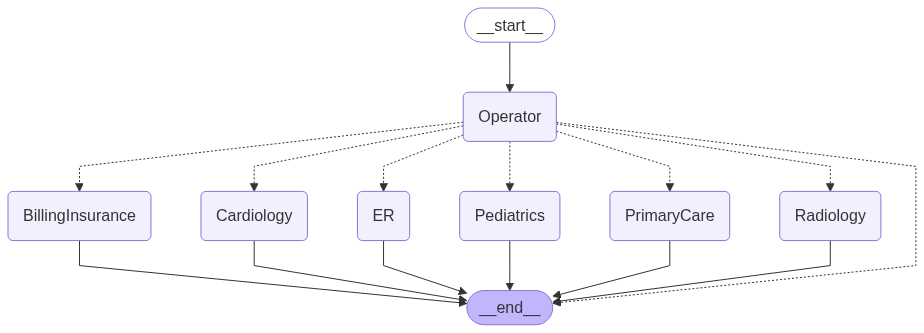

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [15]:
config = {"configurable": {"thread_id": "1"}}
while True:
    user_input = input("User: ")
    print(f"\nUser:\n\n {user_input}")
    if user_input.lower() in {"q", "quit"}:
        print("Goodbye!")
        break
    result = graph.invoke({"inquiry": user_input}, config=config)
    response = result.get("response", "No Response Returned")
    print(textwrap.fill(response, 80))


User:

 Hello?
Hello there, This is Northwestern Memorial Hospital, How can I assist you today?

User:

 My child has a runny nose.
Pediatrics:: A runny nose can be a symptom of various conditions, including RSV
(Respiratory Syncytial Virus). If your child is experiencing additional symptoms
such as a cough, fever, or wheezing, it may be important to monitor them
closely. For infants, watch for severe signs like difficulty breathing, nasal
flaring, chest retractions, or bluish lips. If you have concerns or if your
child is in a high-risk group, please seek medical care. If you need further
assistance, feel free to ask!

User:

 When does this become an emergency?
Pediatrics:: This situation becomes an emergency if your child shows severe
signs such as difficulty breathing, nasal flaring, chest retractions, or bluish
lips. Additionally, if your child is experiencing rapid breathing or
dehydration, you should seek medical care immediately. It's especially important
to monitor infants un